# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [60]:
# using SQLite Table to read data.
con = sqlite3.connect('../Datasets/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [61]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [62]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [63]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [64]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [65]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [66]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [67]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [68]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [69]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [70]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [71]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [72]:
reviewDF = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
reviewDF = reviewDF[:100000]

In [73]:
# Saving dataframe to make sure we are processing same dataset(Train, Test, Cv) across various models.
reviewDF.to_pickle('reviewDF')

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [3]:
reviewDF = pd.read_pickle('reviewDF')

In [4]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [5]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [6]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
rLength = []
# tqdm is for printing the status bar
for sentance in tqdm(reviewDF['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    rLength.append(len(sentance.split(' ')))

100%|██████████| 100000/100000 [00:45<00:00, 2184.29it/s]


In [78]:
preprocessed_reviews[5]

'one movie movie collection filled comedy action whatever else want call'

# [4] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

In [7]:
# Dataframe with review length as extra feature
Dataset = pd.DataFrame(
    {'Review': preprocessed_reviews,
     'length': rLength,
     'Score' : reviewDF['Score']
     
    })

X = Dataset.iloc[:,:2].values
Y = Dataset.Score.values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

X_trainText = np.array(X_train[:,:1])
X_trainText = X_trainText.reshape(X_trainText.shape[0],)

X_testText  = np.array(X_test[:,:1])
X_testText  = X_testText.reshape(X_testText.shape[0],) 

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

vectorizer = CountVectorizer(ngram_range=(1, 2), min_df = 10) 
vectorizer.fit(X_trainText)

X_train_bow = vectorizer.transform(X_trainText)
X_train_bow = preprocessing.normalize(X_train_bow)
print("Train Data Size: ",X_train_bow.shape)

X_test_bow = vectorizer.transform(X_testText)
X_test_bow = preprocessing.normalize(X_test_bow)
print("Test Data Size:  ",X_test_bow.shape)

Train Data Size:  (67000, 37597)
Test Data Size:   (33000, 37597)


In [37]:
# Model Training
model = MultinomialNB()
parameters = {'alpha':np.logspace(-4,4,9)}
gsmnb = GridSearchCV(model, parameters, cv=10, scoring='roc_auc')
gsmnb.fit(X_train_bow, y_train)

train_auc= gsmnb.cv_results_['mean_train_score']
train_auc_std= gsmnb.cv_results_['std_train_score']
cv_auc = gsmnb.cv_results_['mean_test_score'] 
cv_auc_std= gsmnb.cv_results_['std_test_score']

bestAlpha = gsmnb.best_params_['alpha']
print("Best Hyperparameter: "+ str(bestAlpha))

Best Hyperparameter: 0.1


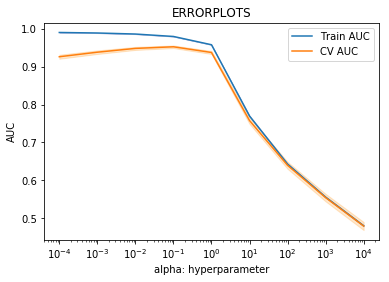

In [38]:
# Train vs CV AUC plot
alpha = np.logspace(-4,4,9)
plt.semilogx(alpha, train_auc, label='Train AUC')
# this code is copied farom here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERRORPLOTS")
plt.show()

#### Testing accuracy on test data

In [39]:
import itertools
def confusionMatrixPlot(YTest, predTest):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(YTest, predTest)
    plt.imshow(cnf_matrix,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(YTest))) # length of classes
    class_labels = ['0','1']
    tick_marks
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    # plotting text value inside cells
    thresh = cnf_matrix.max() / 2.
    for i,j in itertools.product(range(cnf_matrix.shape[0]),range(cnf_matrix.shape[1])):
        plt.text(j,i,format(cnf_matrix[i,j],'d'),horizontalalignment='center',color='black' if cnf_matrix[i,j] >thresh else 'black')
    plt.show();

#### Testing with Test Data

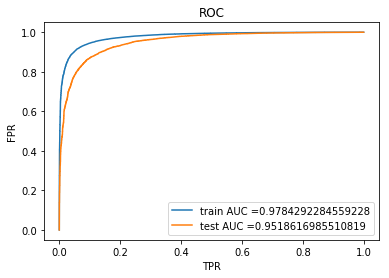

In [40]:
# Testing with Test Data
model = MultinomialNB(alpha=bestAlpha)
model.fit(X_train_bow,y_train)

predTest  = model.predict_log_proba(X_test_bow)
predTrain = model.predict_log_proba(X_train_bow)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC")
plt.show()

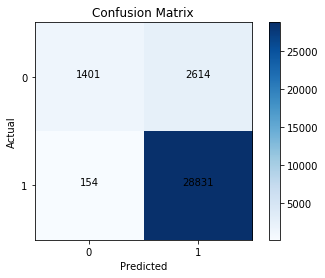

In [41]:
confusionMatrixPlot(y_test,model.predict(X_test_bow))

In [42]:
features = vectorizer.get_feature_names()
featureProb = pd.DataFrame(
    {'feature': vectorizer.get_feature_names(),
     'Probability': model.feature_log_prob_[1]
    })

sortedFeature = featureProb.sort_values('Probability', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [43]:
# Top 15 positive features
sortedFeature[-15:]

,feature,Probability
13065,get,-5.654963
987,amazon,-5.649369
37108,would,-5.533496
5923,coffee,-5.500924
2585,best,-5.484005
11535,flavor,-5.309617
23181,one,-5.215770
25838,product,-5.202532
32222,taste,-5.189898
18837,love,-5.185606


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [44]:
# Top 10 negative features
sortedFeature[:15]

,feature,Probability
33710,threw rest,-15.046070
21910,non returnable,-15.046070
21861,no stars,-15.046070
37072,worst ever,-15.046070
15892,huge disappointment,-15.046070
34162,total waste,-15.046070
37071,worst coffee,-15.046070
4673,cannot return,-14.622735
10653,false advertising,-14.603685
1397,anything special,-14.481837


### Feature Engineering
    - Adding review length as a extra feature.

####  Adding review length as a new feature

In [45]:
# stacking review length with existing feature vector on train dataset
from scipy import sparse
# from sklearn.pipeline import Pipeline, FeatureUnion

reviewLen = pd.to_numeric((X_train[:,-1:]).reshape(X_train.shape[0],))
reviewLen = reviewLen.reshape(X_train.shape[0],1)
X_train_bow_newF = sparse.hstack((X_train_bow,reviewLen))
print("Old Dim: "+str(X_train_bow.shape))
print("New Dim: "+str(X_train_bow_newF.shape))

Old Dim: (67000, 37597)
New Dim: (67000, 37598)


In [46]:
# stacking review length with existing feature vector on test dataset
reviewLen = pd.to_numeric((X_test[:,-1:]).reshape(X_test.shape[0],))
reviewLen = reviewLen.reshape(X_test.shape[0],1)
X_test_bow_newF = sparse.hstack((X_test_bow,reviewLen))
print("Old Dim: "+str(X_test_bow.shape))
print("New Dim: "+str(X_test_bow_newF.shape))

Old Dim: (33000, 37597)
New Dim: (33000, 37598)


In [47]:
# Training model with new feature
model = MultinomialNB()
parameters = {'alpha':np.logspace(-4,4,9)}
gsmnb = GridSearchCV(model, parameters, cv=10, scoring='roc_auc')
gsmnb.fit(X_train_bow_newF, y_train)

train_auc= gsmnb.cv_results_['mean_train_score']
train_auc_std= gsmnb.cv_results_['std_train_score']
cv_auc = gsmnb.cv_results_['mean_test_score'] 
cv_auc_std= gsmnb.cv_results_['std_test_score']

bestAlpha = gsmnb.best_params_['alpha']
print("Best Hyperparameter: "+ str(bestAlpha))

Best Hyperparameter: 0.1


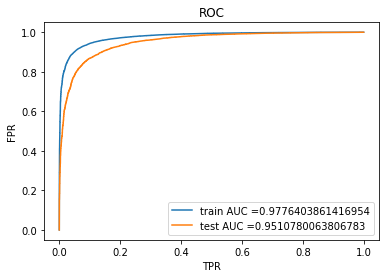

In [48]:
# Testing with Test Data
model = MultinomialNB(alpha=bestAlpha)
model.fit(X_train_bow_newF,y_train)

predTest  = model.predict_log_proba(X_test_bow_newF)
predTrain = model.predict_log_proba(X_train_bow_newF)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC")
plt.show()

#### Observation
    - Model accuracy remains nearly same after adding review length as a extra feature. 

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [49]:
# Vectorization of train and test review
vectorizer = TfidfVectorizer(ngram_range=(1, 2) , min_df=10)
vectorizer.fit(X_trainText)

X_train_tfidf = vectorizer.transform(X_trainText)
X_train_tfidf = preprocessing.normalize(X_train_tfidf)
print("Train Data Size: ",X_train_tfidf.shape)

X_test_tfidf = vectorizer.transform(X_testText)
X_test_tfidf = preprocessing.normalize(X_test_tfidf)
print("Test Data Size: ",X_train_tfidf.shape)

Train Data Size:  (67000, 37597)
Test Data Size:  (67000, 37597)


In [50]:
# Model Training
model = MultinomialNB()
parameters = {'alpha':np.logspace(-4,4,9)}
gsmnb = GridSearchCV(model, parameters, cv=10, verbose=1, scoring='roc_auc')
gsmnb.fit(X_train_tfidf, y_train)

train_auc= gsmnb.cv_results_['mean_train_score']
train_auc_std= gsmnb.cv_results_['std_train_score']
cv_auc = gsmnb.cv_results_['mean_test_score'] 
cv_auc_std= gsmnb.cv_results_['std_test_score']

bestAlpha = gsmnb.best_params_['alpha']
print("Best Hyperparameter: "+ str(bestAlpha))

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Hyperparameter: 0.1


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   10.9s finished


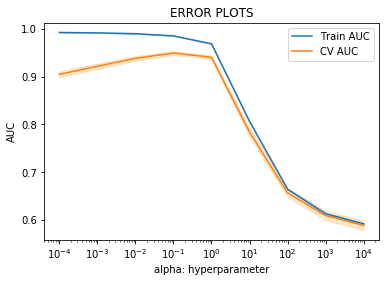

In [51]:
alpha = np.logspace(-4,4,9)
plt.semilogx(alpha, train_auc, label='Train AUC')
# this code is copied farom here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### Testing With Test Data

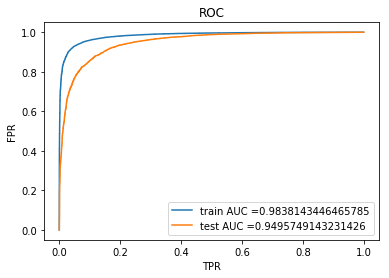

In [52]:
# Testing with Test Data
model = MultinomialNB(alpha=bestAlpha)
model.fit(X_train_tfidf,y_train)

predTest  = model.predict_log_proba(X_test_tfidf)
predTrain = model.predict_log_proba(X_train_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC")
plt.show()

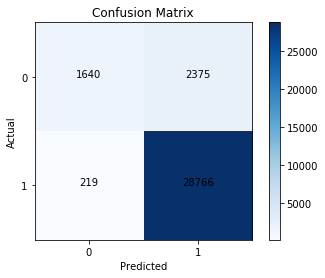

In [53]:
# Confusion Matrix
confusionMatrixPlot(y_test,model.predict(X_test_tfidf))

In [54]:
# Feature probability
features = vectorizer.get_feature_names()
featureProb = pd.DataFrame(
    {'feature': vectorizer.get_feature_names(),
     'Probability': model.feature_log_prob_[1],
    })

sortedFeature = featureProb.sort_values('Probability', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [55]:
# Top 10 positive features
sortedFeature[-15:]

,feature,Probability
11151,find,-6.313242
987,amazon,-6.292849
37108,would,-6.270515
2585,best,-6.143314
11535,flavor,-6.052371
23181,one,-6.025347
5923,coffee,-6.010789
32222,taste,-6.000372
25838,product,-5.970554
18837,love,-5.926327


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [56]:
# Top 10 Negative features
sortedFeature[:15]

,feature,Probability
34162,total waste,-15.019213
37071,worst coffee,-15.019213
15892,huge disappointment,-15.019213
33710,threw rest,-15.019213
21861,no stars,-15.019213
37072,worst ever,-15.019213
21910,non returnable,-15.019213
4673,cannot return,-14.440390
10653,false advertising,-14.339633
1397,anything special,-14.199842


### Feature Engineering

#### Adding review length as a new feature

In [57]:
# stacking review length with existing feature vector on train dataset
from scipy import sparse
# from sklearn.pipeline import Pipeline, FeatureUnion

reviewLen = pd.to_numeric((X_train[:,-1:]).reshape(X_train.shape[0],))
reviewLen = reviewLen.reshape(X_train.shape[0],1)
X_train_tfidf_newF = sparse.hstack((X_train_tfidf,reviewLen))
print("Old Dim: "+str(X_train_tfidf.shape))
print("New Dim: "+str(X_train_tfidf_newF.shape))

Old Dim: (67000, 37597)
New Dim: (67000, 37598)


In [58]:
# stacking review length with existing feature vector on test dataset
reviewLen = pd.to_numeric((X_test[:,-1:]).reshape(X_test.shape[0],))
reviewLen = reviewLen.reshape(X_test.shape[0],1)
X_test_tfidf_newF = sparse.hstack((X_test_tfidf,reviewLen))
print("Old Dim: "+str(X_test_tfidf.shape))
print("New Dim: "+str(X_test_tfidf_newF.shape))

Old Dim: (33000, 37597)
New Dim: (33000, 37598)


In [59]:
# Model Training
model = MultinomialNB()
parameters = {'alpha':np.logspace(-4,4,9)}
gsmnb = GridSearchCV(model, parameters, cv=10, verbose=1, scoring='roc_auc')
gsmnb.fit(X_train_tfidf_newF, y_train)

train_auc= gsmnb.cv_results_['mean_train_score']
train_auc_std= gsmnb.cv_results_['std_train_score']
cv_auc = gsmnb.cv_results_['mean_test_score'] 
cv_auc_std= gsmnb.cv_results_['std_test_score']

bestAlpha = gsmnb.best_params_['alpha']
print("Best Hyperparameter: "+ str(bestAlpha))

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Hyperparameter: 0.1


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   10.6s finished


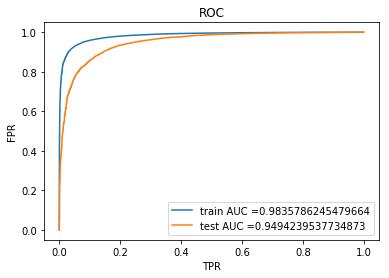

In [60]:
# Testing with Test Data
model = MultinomialNB(alpha=bestAlpha)
model.fit(X_train_tfidf_newF,y_train)

predTest  = model.predict_log_proba(X_test_tfidf_newF)
predTrain = model.predict_log_proba(X_train_tfidf_newF)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC")
plt.show()

#### Observation
    - Model accuracy remains nearly same after adding review length as a extra feature. 

# [6] Conclusions

In [34]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
x.add_row(["BOW", "Multinomial Naive Bayes", 0.1, 0.9518])
x.add_row([" TFIDF", "Multinomial Naive Bayes", 0.1, 0.9495])
print(x)

+------------+-------------------------+----------------+--------+
| Vectorizer |          Model          | Hyperparameter |  AUC   |
+------------+-------------------------+----------------+--------+
|    BOW     | Multinomial Naive Bayes |      0.1       | 0.9518 |
|    TFIDF   | Multinomial Naive Bayes |      0.1       | 0.9495 |
+------------+-------------------------+----------------+--------+
